# LSTM

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import time
import pandas as pd
import plotly.graph_objects as goa
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, GRU, Bidirectional, Embedding, SimpleRNN
from locale import atof, setlocale, LC_NUMERIC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import SGD

from nbeats_keras.model import NBeatsNet as NBeats

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Pré-traitement des données

In [8]:
dataFrame_daily = pd.read_table(r"./Data/DailyData_VolumeProfile.csv", sep = ";", engine = 'python')
df_class = pd.read_table(r"./Data/resultatsClassif.csv", sep=";", engine = 'python')
dataFrame_5 = pd.read_table(r"./Data/FDAXM22-EUREX_5Min.csv", sep=";", engine = 'python')

In [17]:
dataset_spread = np.array(dataFrame_daily['spread'])
dataset_class = np.array(dataFrame_daily['etat variable \'spread\''])
dataset_spread_IB = np.array(dataFrame_daily['IB_Spread'])

dataset_delta = np.array(dataFrame_daily['delta'])

dataset_date = np.array(dataFrame_daily['Date'])
dataset_date5 = np.array(dataFrame_5['Date'])

dataset_vol5 = np.array(dataFrame_5[' Volume'])


dataset_high5 = np.array(dataFrame_5[' High'])
dataset_low5 = np.array(dataFrame_5[' Low'])

dataset_spread5 = dataset_high5 - dataset_low5

#classification2 = df_class.filter(['Classif spread_daily_norm'])
#dataset_class2 = np.array(classification2.values)
#dataset_class2 = np.array([int(e[0]) for e in dataset_class2])

In [18]:
df = pd.DataFrame()
df['Date']= dataset_date
df['Spread']=dataset_spread
df['Class']=dataset_class
#df['Class2']=dataset_class2
df['Spread_IB']=dataset_spread_IB
df['Delta']=dataset_delta

df5 = pd.DataFrame()
df5['Date'] = dataset_date5
df5['Volume'] = dataset_vol5
df5['Spread'] = dataset_spread5

In [19]:
def moyenne_mobile(liste, nb_jour):
    res = []
    for k in range(nb_jour):
        res.append(liste[k])
    for i in range(nb_jour, len(liste)):
        sum_ = 0
        for j in range(i-nb_jour, i):
            sum_ += liste[j]
        res.append(sum_/nb_jour)
    return res

In [20]:
dataHigh = dataFrame_daily['High']
dataLow = dataFrame_daily['Low']

max_ = max(dataHigh)
min_ = min(dataLow)

norm_low_min_max = (dataFrame_daily['Low']-min_)/(max_-min_)
norm_high_min_max = (dataFrame_daily['High']-min_)/(max_-min_)

spread_nom_min_max = norm_high_min_max - norm_low_min_max

df["Low_norm"]=norm_low_min_max
df["High_norm"]=norm_high_min_max
df["Spread_norm"]=spread_nom_min_max

In [21]:
inter = moyenne_mobile(list(dataset_delta), 23)

In [22]:
inter = np.array(inter)

In [23]:
norm_delta = dataset_delta - inter
max_ = max(norm_delta)
min_ = min(norm_delta)
norm_delta = norm_delta / (max_ - min_)

In [24]:
norm_delta

array([ 0.        ,  0.        ,  0.        , ...,  0.00992875,
       -0.0076328 , -0.11733807])

In [25]:
df["Delta_norm"] = norm_delta

## Création d'une classification -, 0, +

In [27]:
class2 = []

for e in dataset_class:
    if e == -2 or e == -1:
        class2.append(0) # la classe - sera indexé 0
    elif e == 0:
        class2.append(1) # la classe 0 sera indexé 1
    elif e == 1 or e == 2:
        class2.append(2) # la classe + sera indexé 2

class2 = np.array(class2)
df['Class2'] = class2

## Création des datasets d'entrainement

In [29]:
# décompte des effectifs des classes & rangement des éléments selon la classes

# le range est celui correspondant à l'année 2021 

indexes_nb = [0,0,0,0,0]
indexes = [[], [], [], [], []]
for i in range(2020, len(dataset_class)-56): 
    if dataset_class[i] == -2:
        indexes_nb[0]+=1
        indexes[0].append(i)
    elif dataset_class[i] == -1:
        indexes_nb[1]+=1
        indexes[1].append(i)
    elif dataset_class[i] == 0:
        indexes_nb[2]+=1
        indexes[2].append(i)
    elif dataset_class[i] == 1:
        indexes_nb[3]+=1
        indexes[3].append(i)
    elif dataset_class[i] == 2:
        indexes_nb[4]+=1
        indexes[4].append(i)

In [30]:
print(indexes_nb)

[37, 39, 127, 15, 39]


In [31]:
# échantillonage 8 éléments par classe répété 10 fois 

def training_sample(nb_jour):
    training = [[],[]]
    
    class_2 = np.arange(nb_jour-1,37)
    class_1 = np.arange(nb_jour-1,39)
    class0 = np.arange(nb_jour-1,127)
    class1 = np.arange(nb_jour-1,15)
    class2 = np.arange(nb_jour-1,39)
    
    X1 = list(df.Spread)
    X2 = list(df.Spread_IB)
    X3 = list(df.Delta_norm)
    
    Y = list(df.Class2)
    
    for i in range(10):
        np.random.shuffle(class_2)
        np.random.shuffle(class_1)
        np.random.shuffle(class0)
        np.random.shuffle(class1)
        np.random.shuffle(class2)

        for n in range(0,8):
            i_2 = indexes[0][class_2[n]]
            i_1 = indexes[1][class_1[n]]
            i0 = indexes[2][class0[n]]
            i1 = indexes[3][class1[n]]
            i2 = indexes[4][class2[n]]

            training[0].append([X1[i_2-nb_jour-1:i_2-1],X2[i_2-nb_jour-1:i_2-1], X3[i_2-nb_jour-1:i_2-1]])
            training[1].append(Y[i_2])

            training[0].append([X1[i_1-nb_jour-1:i_1-1],X2[i_1-nb_jour-1:i_1-1],X3[i_1-nb_jour-1:i_1-1]])
            training[1].append(Y[i_1])

            training[0].append([X1[i0-nb_jour-1:i0-1],X2[i0-nb_jour-1:i0-1],X3[i0-nb_jour-1:i0-1]])
            training[1].append(Y[i0])

            training[0].append([X1[i1-nb_jour-1:i1-1],X2[i1-nb_jour-1:i1-1],X3[i1-nb_jour-1:i1-1]])
            training[1].append(Y[i1])

            training[0].append([X1[i2-nb_jour-1:i2-1],X2[i2-nb_jour-1:i2-1],X3[i2-nb_jour-1:i2-1]])
            training[1].append(Y[i2])
    
    return training

In [32]:
# même échantillonage que précédemment mais cette fois ci on prnd les données ACP 

# les données ACP sont crées à la fin de ce notebook

def training_sample_acp(nb_jour):
    training = [[],[]]
    
    X = list(x)
    
    Y = list(df.Class2)
    
    class_2 = np.arange(nb_jour-1,37)
    class_1 = np.arange(nb_jour-1,39)
    class0 = np.arange(nb_jour-1,127)
    class1 = np.arange(nb_jour-1,15)
    class2 = np.arange(nb_jour-1,39)
    
    for i in range(10):
        np.random.shuffle(class_2)
        np.random.shuffle(class_1)
        np.random.shuffle(class0)
        np.random.shuffle(class1)
        np.random.shuffle(class2)
    
        for n in range(0,8):
            i_2 = indexes[0][class_2[n]]
            i_1 = indexes[1][class_1[n]]
            i0 = indexes[2][class0[n]]
            i1 = indexes[3][class1[n]]
            i2 = indexes[4][class2[n]]

            training[0].append(X[i_2-nb_jour-1:i_2-1])
            training[1].append(Y[i_2])

            training[0].append(X[i_1-nb_jour-1:i_1-1])
            training[1].append(Y[i_1])

            training[0].append(X[i0-nb_jour-1:i0-1])
            training[1].append(Y[i0])

            training[0].append(X[i1-nb_jour-1:i1-1])
            training[1].append(Y[i1])

            training[0].append(X[i2-nb_jour-1:i2-1])
            training[1].append(Y[i2])
    
    
    return training

In [33]:
# dataset sur 2021 entièrement (données mélangées)

def training_sample_whole(nb_jour):
    training = [[], []]
    date = []
    
    X1 = list(df.Spread)
    X2 = list(df.Spread_IB)
    X3 = list(df.Delta_norm)
    
    D = list(df['Date'])
    
    Y1 = list(df.Class)
    Y2 = list(df.Class2) # à sélectionner
    
    randomizer = np.arange(2020,len(X1)-56)
    np.random.shuffle(randomizer)
    
    for i in range(len(randomizer)):
        indice = randomizer[i]
        training[0].append([X1[indice-nb_jour:indice],X2[indice-nb_jour:indice], X3[indice-nb_jour:indice]])
        training[1].append(Y2[indice])
        date.append(D[indice])
    
    return training,date

In [34]:
# dataset sur 2021 entièrement avec données ACP (données mélangées)

def training_sample_whole_ACP(nb_jour):
    training = [[], []]
    
    X = list(x)
    
    Y1 = list(df.Class)
    Y2 = list(df.Class2) # à sélectionner
    
    randomizer = np.arange(2020,len(X)-56)
    np.random.shuffle(randomizer)
    
    for i in range(len(randomizer)):
        indice = randomizer[i]
        training[0].append(X[indice-nb_jour-1:indice-1])
        training[1].append(Y2[indice])
    
    return training

In [ ]:
def rf_training_sample(nb_jour):
    training = [[], []]
    date = []
    
    X1 = list(df.Spread_IB)
    
    D = list(df['Date'])
    
    Y1 = list(df.Class)
    Y2 = list(df.Class2) # à sélectionner
    
    randomizer = np.arange(2020,len(X1)-56)
    np.random.shuffle(randomizer)
    
    for i in range(len(randomizer)):
        date_ = D[indice]
        X2 = list(df5.loc[df5.Date == date_].Volume)
        X3 = list(df5.loc[df5.Date == date_].Spread)
        training[0].append([X1[indice-nb_jour+1:indice+1]])
        training[1].append(Y2[indice])
    

In [39]:
#training7 = training_sample(7)
training7,date = training_sample_whole(7)
x_train7 = training7[0]
y_train7 = training7[1]

In [ ]:
#training7 = training_sample_acp(7)
training7 = training_sample_whole_ACP(7)
x_train7 = training7[0]
y_train7 = training7[1]

In [40]:
x_train7, y_train7 = np.array(x_train7), np.array(y_train7)

In [41]:
x_train7.shape

(257, 3, 7)

## Création des étiquettes

In [ ]:
# classification 5 modalités (-2,-1,0,1,2)
def labels(Y):
    res = []
    for e in Y:
        intermediaire = [0,0,0,0,0]
        intermediaire[e] = 1
        res.append(intermediaire)
    return np.array(res)

y_train7 = y_train7 + 2
y_train7 = labels(y_train7)

In [42]:
# classification 3 modalités (-,0,+)
def labels2(Y):
    res = []
    for e in Y:
        intermediaire = [0,0,0]
        intermediaire[e] = 1
        res.append(intermediaire)
    return np.array(res)

y_train7 = labels2(y_train7)

In [43]:
y_train7

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0,

## Changement de dimension des vecteurs de la base d'entrainement

In [44]:
x_train7 = x_train7.reshape((257,21))
x_train7[3]

array([ 1.32000000e+02,  1.07000000e+02,  2.17000000e+02,  1.78000000e+02,
        1.45000000e+02,  7.50000000e+01,  9.60000000e+01,  3.20000000e+01,
        4.70000000e+01,  7.80000000e+01,  4.50000000e+01,  3.70000000e+01,
        5.20000000e+01,  2.70000000e+01, -2.93583940e-02,  5.86709453e-02,
        1.18908181e-01,  1.10484595e-01,  6.17691441e-02, -2.71464864e-02,
        3.55700724e-02])

In [45]:
x_train7.shape

(257, 21)

## Création des modèles

In [46]:
# with RandomizedSearchCVCreate, a grid of tuning parameters is built
# then a random search will be performed to test which parameter values yield the best 
# random forest estimate (see below).
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
# max_features is the number of dimension considered to select the best split (the dimension along which a cell is cut)
max_features = ['log2', 'sqrt']
# The maximum depth of the tree corresponds to the maximum number of levels of the tree. 
# If not given, splits are performed until all cells contain less than min_samples_split samples.
max_depth = np.arange(5,100,5)
# min_samples_split is the minimum number of samples in a cell to allow a split.
min_samples_split = [2, 3, 4, 5, 6, 7, 8]
# A split is considered in the tree if it leaves at least min_samples_leaf training samples in each 
# subcell obtained after the spliting process.
min_samples_leaf = [1, 2, 3, 4]
# if bootstrap is true all the training dataset is used to build each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
 'n_estimators': [200,
                  200,
                  201,
                  202,
                  203,
                  204,
                  204,
                  205,
                  206,
                  207,
                  208,
                  208,
                  209,
                  210,
                  211,
                  212,
                  212,
                  213,
    

In [ ]:
model = tf.keras.models.Sequential()
# Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
#model.add(Embedding(20, 21))
#model.add(Dropout(0.2))
model.add(SimpleRNN(5))
#model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2, activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

sfc = tfa.losses.SigmoidFocalCrossEntropy()
model.build((None, 21, 1))
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
input_dim, output_dim = 21, 3
model2 = NBeats(
            backcast_length=21, forecast_length=output_dim,
            stack_types=(NBeats.GENERIC_BLOCK, NBeats.GENERIC_BLOCK),
            nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
            hidden_layer_units=64
        )
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model3 = tf.keras.models.Sequential()
model3.add(LSTM(3, input_shape=(21,1),dropout=0.2, recurrent_dropout=0.2, activation='softmax'))
#model3.add(Dense(3,activation="softmax"))


sfc = tfa.losses.SigmoidFocalCrossEntropy()

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Création des datasets de validation

In [47]:
X1 = list(df.Spread)
X2 = list(df.Spread_IB)
X3 = list(df.Delta_norm)

#X = list(x) #si n'éxecute pas il faut faire l'acp en fin de notebook

Y1 = list(df.Class)
Y2 = list(df.Class2) # à sélectionner

x_test7 = []
y_test7 = []

for i in range(2278, 2333):
    x_test7.append([X1[i-7:i],X2[i-7:i],X3[i-7:i]])
    #x_test7.append(X[i-8:i-1])
    y_test7.append(Y2[i])

In [48]:
x_test7, y_test7 = np.array(x_test7), np.array(y_test7)

In [49]:
x_test7.shape

(55, 3, 7)

In [50]:
x_test7 = x_test7.reshape((55,21))

In [ ]:
# pour la classification à 5 modalités
y_test7 = y_test7 + 2
y_test7 = labels(y_test7)

In [51]:
# pour la classification 3 modalités
y_test7 = labels2(y_test7)

## Entrainement et affichages

In [62]:
rf = RandomForestRegressor()
# Random search among  all parameters (the number of possible combination is given. It is not a complete grid search !!!). 
# search across n_iter = 10 different combinations with a default 3-fold cross validation.
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, n_jobs = -1)

rf_random.fit(x_train7,y_train7)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8],
                                        'n_estimators': [20

[CV 2/3; 2/100] START bootstrap=False, max_depth=14, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=895
[CV 2/3; 2/100] END bootstrap=False, max_depth=14, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=895; total time=   1.6s
[CV 3/3; 5/100] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=880
[CV 3/3; 5/100] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=880; total time=   1.5s
[CV 3/3; 8/100] START bootstrap=True, max_depth=58, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=698
[CV 3/3; 8/100] END bootstrap=True, max_depth=58, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=698; total time=   1.3s
[CV 3/3; 10/100] START bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=871
[CV 3/3; 10/100] END bootstrap=True, m

[CV 2/3; 1/100] START bootstrap=True, max_depth=36, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=700
[CV 2/3; 1/100] END bootstrap=True, max_depth=36, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=700; total time=   1.4s
[CV 1/3; 4/100] START bootstrap=False, max_depth=78, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=346
[CV 1/3; 4/100] END bootstrap=False, max_depth=78, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=346; total time=   0.6s
[CV 2/3; 6/100] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=787
[CV 2/3; 6/100] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=787; total time=   1.4s
[CV 1/3; 9/100] START bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=805
[CV 1/3; 9/100] END bootstrap=True, max

[CV 2/3; 3/100] START bootstrap=False, max_depth=24, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=905
[CV 2/3; 3/100] END bootstrap=False, max_depth=24, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=905; total time=   1.5s
[CV 1/3; 5/100] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=880
[CV 1/3; 5/100] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=880; total time=   1.5s
[CV 1/3; 8/100] START bootstrap=True, max_depth=58, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=698
[CV 1/3; 8/100] END bootstrap=True, max_depth=58, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=698; total time=   1.3s
[CV 1/3; 10/100] START bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=871
[CV 1/3; 10/100] END bootstrap=True, m

[CV 3/3; 1/100] START bootstrap=True, max_depth=36, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=700
[CV 3/3; 1/100] END bootstrap=True, max_depth=36, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=700; total time=   1.4s
[CV 3/3; 3/100] START bootstrap=False, max_depth=24, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=905
[CV 3/3; 3/100] END bootstrap=False, max_depth=24, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=905; total time=   1.6s
[CV 3/3; 7/100] START bootstrap=True, max_depth=88, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=888
[CV 3/3; 7/100] END bootstrap=True, max_depth=88, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=888; total time=   1.7s
[CV 1/3; 11/100] START bootstrap=False, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=352
[CV 1/3; 11/100] END bootstrap=False, m

[CV 1/3; 2/100] START bootstrap=False, max_depth=14, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=895
[CV 1/3; 2/100] END bootstrap=False, max_depth=14, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=895; total time=   1.5s
[CV 2/3; 5/100] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=880
[CV 2/3; 5/100] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=880; total time=   1.5s
[CV 2/3; 8/100] START bootstrap=True, max_depth=58, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=698
[CV 2/3; 8/100] END bootstrap=True, max_depth=58, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=698; total time=   1.3s
[CV 2/3; 10/100] START bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=871
[CV 2/3; 10/100] END bootstrap=True, m

In [53]:
# display the best parameters
rf_random.best_params_

{'n_estimators': 965,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': True}

In [ ]:
class PredictionCallback(tf.keras.callbacks.Callback):    
  def on_test_begin(self, epoch, logs={}):
    x,y = self.validation_data
    print(x)
    y_pred = self.model.predict(self.validation_data[0])
    print('prediction: {} at epoch: {}'.format(y_pred, epoch))

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_train, y_train):
        self.model = model
        self.x_train = x_train

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x_train)
        print('y predicted: ', y_pred)

In [ ]:
print(x_test7[0].shape)

In [ ]:
history = model3.fit(x_train7, y_train7,batch_size=5, epochs=10, validation_data=(x_test7,y_test7))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs£ validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Prédictions

In [ ]:
predictions = model3.predict(x_test7)

In [54]:
best_random = rf_random.best_estimator_
predictions = best_random.predict(x_test7)

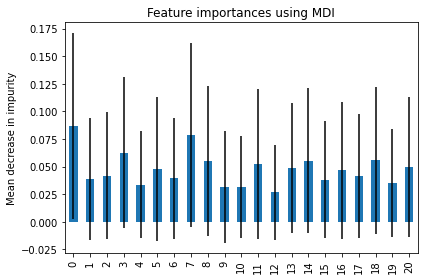

In [61]:
importances = best_random.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_random.estimators_], axis=0)
forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [55]:
# reformatage des données prédites
pred = []
for p in predictions:
    pred.append(np.argmax(p))
pred = np.array(pred)

# reformartage des données de validation
y_test_bis = []
for p in y_test7:
    y_test_bis.append(np.argmax(p))
y_test_bis = np.array(y_test_bis)

In [56]:
# reformartage des données de validation
y_train_bis = []
for p in y_train7:
    y_train_bis.append(np.argmax(p))
y_train_bis = np.array(y_train_bis)

In [ ]:
# uniquement pour 5 modalités
pred = pred + 2

In [57]:
# affichage des outputs des prédictions 
print(pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0]


## MSE

In [ ]:
print(math.sqrt(np.mean(pred - y_test_bis)**2))

## Matrice de confusion

In [ ]:
cf_matrix = confusion_matrix(y_test_bis, pred)

In [ ]:
# passage en ppurcentage
cf_matrix_percent = np.zeros((3,3))
for i in range(3):
    somme=np.sum(cf_matrix[i])
    for j in range(3):
        cf_matrix_percent[i][j]= 100*cf_matrix[i][j]/somme


In [ ]:
print(cf_matrix)
print(cf_matrix_percent)

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(cf_matrix_percent, annot=True, cmap='Blues', fmt=".2f")

ax.set_title('Matrice de Confusion avec labels \n');
ax.set_xlabel('\nValeurs Prédites')
ax.set_ylabel('Valeurs Réelles');
for t in ax.texts: t.set_text(t.get_text() + " %")
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-', '0', '+' ])
ax.yaxis.set_ticklabels(['-', '0', '+'])

## Display the visualization of the Confusion Matrix.
plt.show()


In [ ]:
accuracy = 0
for i in range(len(pred)):
    if pred[i] == y_test_bis[i]:
        accuracy += 1
print(accuracy/len(pred))

In [ ]:
print(classification_report(y_test_bis, pred))

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
df2 = pd.read_table(r"./Data/DailyData_VolumeProfile.csv", sep = ";", engine = 'python')

In [ ]:
target_cols = ['Open', 'High', 'Low', 'Last', 'Volume', '# of Trades',
       'OHLC Avg', 'HLC Avg', 'HL Avg', 'Bid Volume', 'Ask Volume', 
       'priceChange', 'delta', 'spread', 'IBH', 'IBL', 'IB_Spread', 'VAH', 'VAL']

In [ ]:
df2[target_cols]

In [ ]:
scaling=StandardScaler()

In [ ]:
scaling.fit(df2[target_cols])
Scaled_data=scaling.transform(df2[target_cols])

In [ ]:
principal=PCA(n_components=3)

In [ ]:
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)

## Réhaussage des données pour faire rentrer les données dans un embedding

In [ ]:
min_x = np.min(x)
print(min_x)

In [ ]:
x = x + abs(min_x)

## Résultats de l'ACP

In [ ]:
x

In [ ]:
np.max(x)

In [ ]:
t = df2["etat variable 'spread'"]

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(x[:,0],x[:,1],c=t,cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

In [ ]:
def plot_inertia(pca):
    plt.figure(figsize=(20,10))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Components')
    plt.ylabel('Cumulated inertia')
    plt.show()

In [ ]:
plot_inertia(principal)